### Building the Image Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers
from keras.models import load_model, Model

import numpy as np

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_list_filenames=[]
train_list_labels=[]
dstpath='/content/drive/MyDrive/Proyect Final Vision/train'
test_df = pd.read_csv('/content/drive/MyDrive/Proyect Final Vision/test.txt', sep=" ", header=None)
test_df.columns=['patient id', 'filenames', 'labels', 'data source' ]
test_df=test_df.drop(['patient id', 'data source'], axis=1 )
print (test_df.head())
train_txt= open("/content/drive/MyDrive/Proyect Final Vision/train.txt","r")
train_list=train_txt.readlines()
for line in train_list:
    split=line.split(' ')    
    if len(split)>4:        
        fname=os.path.join(dstpath, split[2])        
        label=split [3]
    else:        
        fname=os.path.join(dstpath, split[1])
        label=split[2]
    train_list_filenames.append(fname)
    train_list_labels.append(label)
Ftrseries=pd.Series(train_list_filenames, name='filenames')
Ltrseries=pd.Series(train_list_labels, name='labels')
df=pd.concat([Ftrseries, Ltrseries], axis=1)
print (df.head())
balance=df['labels'].value_counts()
print (balance)

                                   filenames    labels
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
                                           filenames    labels
0  /content/drive/MyDrive/Proyect Final Vision/tr...  negative
1  /content/drive/MyDrive/Proyect Final Vision/tr...  negative
2  /content/drive/MyDrive/Proyect Final Vision/tr...  negative
3  /content/drive/MyDrive/Proyect Final Vision/tr...  negative
4  /content/drive/MyDrive/Proyect Final Vision/tr...  negative
negative    13793
positive     2158
Name: labels, dtype: int64


Se balancea el dataset

In [3]:
file_count = 2158
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts()) # check to see each class has 200 samples
print (len(df))

negative    2158
positive    2158
Name: labels, dtype: int64
4316


In [4]:
tsplit=.9
train_df, valid_df=train_test_split(df, train_size=tsplit, shuffle=True, random_state=123)
print(len(train_df))
len(valid_df)

3884


432

In [5]:
def scalar(img):
  return (img - img.min()) * (255/(img.max() - img.min()))

In [6]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(preprocessing_function=scalar)
validation_datagen = ImageDataGenerator(preprocessing_function=scalar)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
        train_df, x_col='filenames', y_col='labels', target_size=(224, 224), class_mode='binary', color_mode='rgb', shuffle=False, batch_size=60)

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_dataframe(
        valid_df, x_col='filenames', y_col='labels', target_size=(224, 224), class_mode='binary', color_mode='rgb', shuffle=False, batch_size=60)

Found 3884 validated image filenames belonging to 2 classes.
Found 432 validated image filenames belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(MobileNetV3Large(include_top = False, weights="imagenet", input_shape=(224, 224, 3)))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(Dense(1, activation = 'sigmoid'))
#model.layers[0].trainable = False

17612800/17605208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,227,713
Trainable params: 4,203,313
Non-trainable params: 24,400
_________________________________________________________________


In [7]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 2
    else:
        return num_samples // batch_size

In [8]:
nb_train_sample = train_df.shape[0] * 0.9
#nb_train_sample = 1165 * 0.9

nb_validation_sample = train_df.shape[0] - nb_train_sample
#nb_validation_sample = 1165 - nb_train_sample

nb_test_sample = valid_df.shape[0]
#nb_test_sample = 130

print(nb_train_sample)
print(nb_validation_sample)
print(nb_test_sample)

3495.6
388.4000000000001
432


In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse','mae'])

In [ ]:
callbacks1 = [
    EarlyStopping(monitor='val_loss',patience=2, mode='min', verbose=1, min_delta=0.0001),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-10, mode='min', verbose=1),
    ModelCheckpoint(filepath='/content/drive/MyDrive/Proyect Final Vision/Covid/callbackTest2.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    CSVLogger('/content/drive/MyDrive/Proyect Final Vision/Covid/csvloggerTest2.csv', append=False, separator=",")
    ]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=get_steps(nb_train_sample, 60),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=get_steps(nb_validation_sample, 60),
    verbose=1,
    callbacks=callbacks1
)

Epoch 1/50
60/60 [==============================] - 1440s 24s/step - loss: 0.2584 - accuracy: 0.9079 - mse: 0.0706 - mae: 0.1164 - val_loss: 0.1683 - val_accuracy: 0.9329 - val_mse: 0.0452 - val_mae: 0.0783

Epoch 00001: val_loss improved from inf to 0.16829, saving model to /content/drive/MyDrive/Proyect Final Vision/Covid/callbackTest2.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
60/60 [==============================] - 711s 12s/step - loss: 0.0631 - accuracy: 0.9802 - mse: 0.0158 - mae: 0.0316 - val_loss: 0.1851 - val_accuracy: 0.9491 - val_mse: 0.0401 - val_mae: 0.0544

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00002: val_loss did not improve from 0.16829
Epoch 3/50
60/60 [==============================] - 701s 12s/step - loss: 0.0207 - accuracy: 0.9933 - mse: 0.0054 - mae: 0.0133 - val_loss: 0.2131 - val_accuracy: 0.9514 - val_mse: 0.0404 - val_mae: 0.0551

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00003: val_loss did not improve from 0.16829
Epoch 00003: early stopping


In [15]:
model = load_model("/content/drive/MyDrive/Proyect Final Vision/model/MobileNetV3LargeModel.hdf5")

In [16]:
validation_generator.reset()
preds=model.predict(validation_generator, batch_size=60, steps=get_steps(nb_validation_sample, 60), verbose=1)

8/8 [==============================] - 31s 3s/step


In [17]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(validation_generator.classes, preds)
auc_rf = auc(fpr_rf, tpr_rf)

In [23]:
tpr_rf

array([0.        , 0.55299539, 0.56221198, 0.59447005, 0.59907834,
       0.60829493, 0.63133641, 0.640553  , 0.65898618, 0.66820276,
       0.67281106, 0.68202765, 0.70506912, 0.71428571, 0.73732719,
       0.74654378, 0.81105991, 0.81105991, 0.85714286, 0.85714286,
       0.86635945, 0.86635945, 0.88479263, 0.88479263, 0.88940092,
       0.88940092, 0.89861751, 0.89861751, 0.90322581, 0.90322581,
       0.94009217, 0.94009217, 0.94470046, 0.94470046, 0.95391705,
       0.95391705, 0.95852535, 0.95852535, 0.96313364, 0.96313364,
       0.96774194, 0.96774194, 0.97235023, 0.97235023, 0.97695853,
       0.97695853, 0.98156682, 0.98156682, 0.99078341, 0.99078341,
       0.99539171, 0.99539171, 1.        , 1.        ])

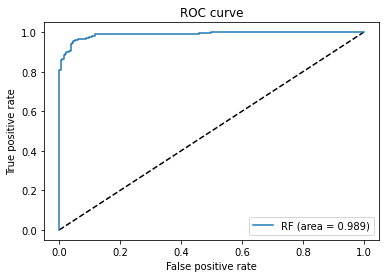

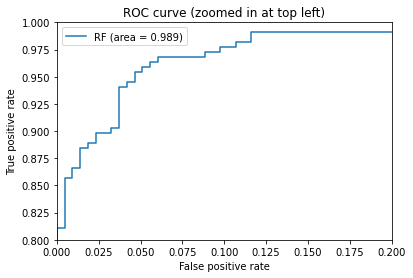

In [18]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
preds=model.predict(validation_generator, batch_size=60, steps=get_steps(nb_validation_sample, 60), verbose=1)
y_preds =  np.rint(preds)
y_true = validation_generator.classes

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       215
           1       0.95      0.95      0.95       217

    accuracy                           0.95       432
   macro avg       0.95      0.95      0.95       432
weighted avg       0.95      0.95      0.95       432



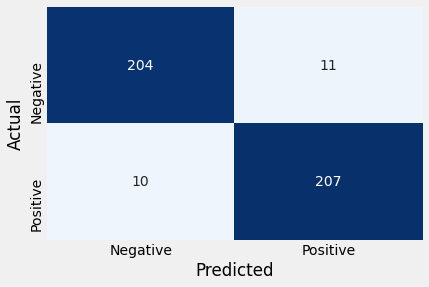

In [ ]:
cm = confusion_matrix(y_true, y_preds)
x_axis_labels=["Negative","Positive"]
y_axis_labels=["Negative","Positive"]
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,xticklabels=x_axis_labels, yticklabels=y_axis_labels )
plt.xlabel("Predicted")
plt.ylabel("Actual")
clr=classification_report(y_true,y_preds)
print("Classification Report:\n----------------------\n", clr)

In [ ]:
model.save("/content/drive/MyDrive/Proyect Final Vision/Covid/NoEntiendo.hdf5")